

```
# This is formatted as code
```


Author: Karan Kokabisaghi
Strategy Analyst| Data Scientist|Python Developer

Date: 22 November 2022

Version: 1.0

- This code is to automate the computations within a network. 
- The following code is the continuation of the "Networkx_DecisionBoost" article in my repository. 
  - There is a network "G" with 6 nodes (node id, node type, nr_children) and 9 edges (each edge has attributes. e.g.cost, probability, action). 
  

# Mount google drive or read data from your directory on the computer

In [ ]:
# connect to the working directory
from google.colab import drive
drive.mount('/content/drive') 
import os
os.chdir(r'/content/drive/My Drive') # Define your directory in your google drive
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Financial_Crime_Py_Codes


In [ ]:
#!pip install xlrd
import xlrd # to import/read excel file
import networkx as nx


# Build the network
- Read Data from excel file

In [ ]:
# Open Workbook :
#--------------------------------------
loc = (r"/content/drive/My Drive/example_excel_datascience.xlsx")

wb = xlrd.open_workbook(loc)
sheet_nodes = wb.sheet_by_name("Node_info") # read sheet by name
print(sheet_nodes)

edge from  1 to  2 action: strategy_1_yes , prob 1.0 , cost -10.0
edge from  1 to  6 action: strategy_1_no , prob 1.0 , cost 0.0
edge from  2 to  3 action: meet_criteria_yes , prob 0.0 , cost 0.0
edge from  2 to  6 action: meet_criteria_no , prob 0.0 , cost 0.0
edge from  3 to  4 action: strategy_2_yes , prob 1.0 , cost -10.0
edge from  3 to  6 action: strategy_2_no , prob 1.0 , cost 0.0
edge from  4 to  5 action: meet_criteria_yes , prob 0.0 , cost 0.0
edge from  4 to  6 action: meet_criteria_no , prob 0.0 , cost 0.0
edge from  5 to  6 action: Project_done , prob 1.0 , cost 0.0


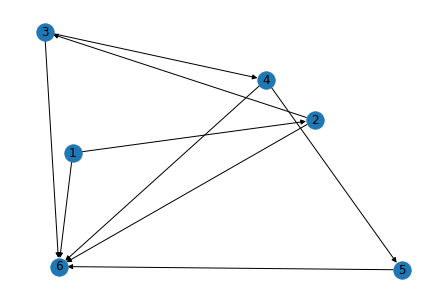

In [ ]:
G = nx.DiGraph()
checklist_col = {}
for row_id in range(1,sheet_nodes.nrows): 
  #row = 0 is the titles 
  #node_id in Excel first column
  #1. get the node_id for this row and add it to the network
  node_id = int(sheet_nodes.cell_value(row_id,0))
  G.add_node(node_id)
   
  # add node type to the network:
  node_type={}
  node_type.update({node_id: dict(zip(['node_type'],[sheet_nodes.cell_value(row_id, 1)]))}) 
  nx.set_node_attributes(G, node_type)


  nr_children =  int(sheet_nodes.cell_value(row_id,2))
  #
  # To matrix check, add a column that contains matrix names to the network node 
  checklist_col.update({node_id: dict(zip(['checklist_name'],[sheet_nodes.cell_value(row_id, 4)]))}) # node_type in Excel second column  
  nx.set_node_attributes(G, checklist_col)
  # 2. CYCLE OVER ALL THE Children
  children_of_this_node = [] #a list to collect each loop 
  col_offset = 5 
  nr_features_per_edge = 4 
  for k in range(1,nr_children+1):
    '''
    read the k-th child's node_id at 
     the following location in the excel sheet_nodes
    '''
    child_node_id_col0 = col_offset-1+(k-1)*nr_features_per_edge+1
    child_node_id  = int(sheet_nodes.cell(row_id, child_node_id_col0).value)
    children_of_this_node.append(child_node_id)
    
    # 3. Find the corresponding attributes : column order : child_id, action, prob, cost
    attr_action_col0 = child_node_id_col0 + 1
    edge_action = sheet_nodes.cell(row_id, attr_action_col0).value
    attr_prob_col0 = child_node_id_col0 + 2
    edge_prob = sheet_nodes.cell(row_id, attr_prob_col0).value
    attr_cost_col0 = child_node_id_col0 + 3 
    edge_cost = sheet_nodes.cell(row_id, attr_cost_col0).value  
    print('edge from ', node_id, 'to ', child_node_id, 
   'action:', edge_action, 
   ', prob', edge_prob, ', cost', edge_cost)
    G.add_edge(node_id, child_node_id, action = edge_action, prob = edge_prob, cost = edge_cost ) 
nx.draw(G,with_labels=True)

# Find all the path

In [ ]:
path = nx.all_simple_paths(G, 1, 6)
path = list(path)
print('path:' ,path)

path: [[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 6], [1, 2, 3, 6], [1, 2, 6], [1, 6]]


# Compute the discounted value of the path

In [ ]:

class Path():

  def __init__(self, node_seq, G):
    self.node_seq = node_seq
    self.G = G 
  def compute_cost_prob(self):
    G = self.G
    node_seq = self.node_seq
    node_seq_len = len(self.node_seq)

    # Create list of transitions (each transition is a 2-tuple) 
    transitions = [(a,b) for a,b in zip(node_seq[:-1], node_seq[1:])]
          
    cost_total = 0  # initialise total cost accured along path 
    prob_total = 1  # probability of path 
    seq_action = [] # To store actions of a path
    

    for n in node_seq:
      
      print('\n Passing through node', n, 'which is of type: ', G.nodes[n]['node_type'])

      #------------------
      # Find the corresponding transition (with the current node as initial node)
      #------------------
      transitions = [(a,b) for a,b in zip(node_seq[:-1], node_seq[1:])]

      if n != node_seq[-1]: # if not terminal

        current_transition = [this_transition for this_transition in transitions if this_transition[0] == n]
        print('-- current transition ' , current_transition)

        node_from  = current_transition[0][0]    
        node_to = current_transition[0][1]
        print('this is from ', node_from, 'to', node_to)
        #------------------
        # Find actions from node_from to the node_to
        #------------------
        edge_attr = G[node_from][node_to]
        print('edge attributes:' , edge_attr)
        
  
        cost_increment = edge_attr['cost']
        print('-- cost_increment = ', cost_increment)
       
        cost_total = cost_total + cost_increment
        prob_total = prob_total * edge_attr['prob'] 
        print('-- Total cost = ',cost_total )
        print('-- Total prob = ', prob_total ) 
    
      else:  #  for a terminal node there is only one action hence: 
        print('This is the end of sequence and final cost/prob')
        edge_attr = {'action': 'End'}
        cost_total = cost_total
        prob_total = prob_total
        print('-- Total cost = ', cost_total )
        print('-- Total prob = ', prob_total ) 
                     
      seq_action.append(edge_attr['action'])
     
      path_characteristics = {
          'path_cost': cost_total, 
          'path_prob'  : prob_total,
          'path_action': seq_action}

    return path_characteristics


# Run the code for an example path:

In [ ]:
example_path = path[0]
Network_res = Path(example_path, G)
path_characteristics = Network_res.compute_cost_prob()


 Passing through node 1 which is of type:  Decision
-- current transition  [(1, 2)]
this is from  1 to 2
edge attributes: {'action': 'strategy_1_yes', 'prob': 1.0, 'cost': -10.0}
-- cost_increment =  -10.0
-- Total cost =  -10.0
-- Total prob =  1.0

 Passing through node 2 which is of type:  Event
-- current transition  [(2, 3)]
this is from  2 to 3
edge attributes: {'action': 'meet_criteria_yes', 'prob': 0.5, 'cost': 0.0}
-- cost_increment =  0.0
-- Total cost =  -10.0
-- Total prob =  0.5

 Passing through node 3 which is of type:  Decision
-- current transition  [(3, 4)]
this is from  3 to 4
edge attributes: {'action': 'strategy_2_yes', 'prob': 1.0, 'cost': -10.0}
-- cost_increment =  -10.0
-- Total cost =  -20.0
-- Total prob =  0.5

 Passing through node 4 which is of type:  Event
-- current transition  [(4, 5)]
this is from  4 to 5
edge attributes: {'action': 'meet_criteria_yes', 'prob': 0.5, 'cost': 0.0}
-- cost_increment =  0.0
-- Total cost =  -20.0
-- Total prob =  0.25

 P